# VRNN.ipynb

A PyTorch implementation of the [Variational Recurrent Neural Network](https://papers.nips.cc/paper_files/paper/2015/file/b618c3210e934362ac261db280128c22-Paper.pdf)



In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import lovely_tensors as lt
lt.monkey_patch()
%cd ./data/

/home/z/Dropbox (OIST)/code/python/pytorch/deep_explorations/rnn/data


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

device = cuda:0


In [3]:
# Load training data
fname = 'circle2_triangle2_eight2_random.pkl'
# fname = 'circle10_1.pkl'
with open(fname, 'rb') as f:
    coordinates = pickle.load(f)

Coordinates shape: torch.Size([954, 2])


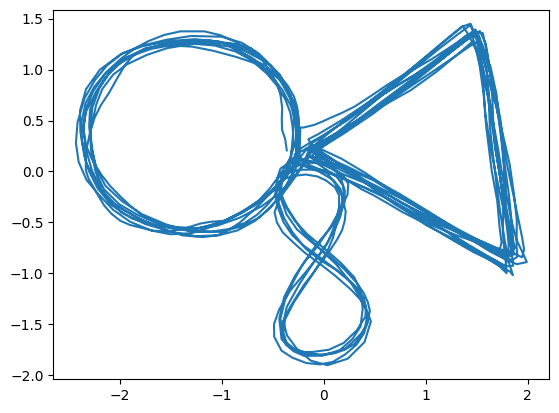

In [4]:
# plot the loaded array
fig = plt.figure()
plt.axis('equal')
plt.plot(coordinates[:,0], coordinates[:,1])

coordinates = torch.tensor(coordinates, dtype=torch.float32)
print(f"Coordinates shape: {coordinates.shape}")

In [5]:
# some utility functions

class FFP(nn.Module):
    """ A feedforward perceptron. """
    def __init__(self, sizes, nltypes, bias=True):
        """
            sizes: list with size of each layer.
            nltypes: list with nonlinearity type for each inner or
                output layer. Entries are 'relu', 'sig', 'tanh', 'soft',
                or 'linear'.
            bias: whether the layers have a bias unit
        """
        assert len(sizes)-1 == len(nltypes), "length mismatch in nltypes, sizes"
        super(FFP, self).__init__()
        # Add activation functions
        self.nlfs = []
        for nltype in nltypes:
            if nltype == "relu":
                self.nlfs.append(nn.ReLU())
            elif nltype == "sig":
                self.nlfs.append(nn.Sigmoid())
            elif nltype == "tanh":
                self.nlfs.append(nn.Tanh())
            elif nltype == "soft":
                self.nlfs.append(nn.Softplus())
            elif nltype == "linear":
                self.nlfs.append("linear")
            else:
                raise ValueError(f"unknown nonlinearity {nltype}")
        # create layers
        self.bias = bias
        self.sizes = sizes
        layers = []
        for lidx in range(1,len(sizes)):
            layers.append(nn.Linear(sizes[lidx-1], sizes[lidx], bias=bias))
        self.layers = nn.ModuleList(layers)
                
    def forward(self, x):
        for lidx, layer in enumerate(self.layers):
            if self.nlfs[lidx] == "linear":
                x = layer(x)
            else:
                x = self.nlfs[lidx](layer(x))
        return x

class normal_FFP(nn.Module):
    """ A FFP that outputs parameters for a multivariate normal distribution.
    
        This is the same as the FFP class, except that the output layer is
        duplicated by concatenating an extra set of units with sigmoidal or
        softplus activation functions. This extra set of units corresponds to
        the entries of a diagonal covariance matrix, whereas the regular
        outputs corresponds to the means.
    """
    def __init__(self, sizes, nltypes, bias=True, use_soft=True):
        """
            sizes: list with size of each layer.
            nltypes: list with nonlinearity type for each inner or
                output layer. Entries are 'relu', 'sig', 'tanh', 'soft',
                or 'linear'.
            bias: whether the layers have a bias unit
            use_soft: if True, the units for the covariance matrix use a
                Softplus nonlinearity. If False, they use a Sigmoid.
        """
        assert len(sizes)-1 == len(nltypes), "length mismatch in nltypes, sizes"
        super(normal_FFP, self).__init__()
        self.n_layers = len(nltypes)
        # Add activation functions
        self.nlfs = []
        for nltype in nltypes:
            if nltype == "relu":
                self.nlfs.append(nn.ReLU())
            elif nltype == "sig":
                self.nlfs.append(nn.Sigmoid())
            elif nltype == "tanh":
                self.nlfs.append(nn.Tanh())
            elif nltype == "soft":
                self.nlfs.append(nn.Softplus())
            elif nltype == "linear":
                self.nlfs.append("linear")
            else:
                raise ValueError(f"unknown nonlinearity {nltype}")
        if use_soft:
            self.cov_nl = nn.Softplus()
        else:
            self.cov_nl = nn.Sigmoid()
        # create layers
        self.bias = bias
        self.sizes = sizes
        layers = []
        for lidx in range(1,len(sizes)):
            layers.append(nn.Linear(sizes[lidx-1], sizes[lidx], bias=bias))
        # the last element in layers will be the sigmoidal variance layer
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=bias))
        self.layers = nn.ModuleList(layers)
                
    def forward(self, x):
        for lidx, layer in enumerate(self.layers[:-1]):
            if lidx == self.n_layers - 1:
                y = self.cov_nl(self.layers[-1](x))
            if self.nlfs[lidx] == "linear":
                x = layer(x)
            else:
                x = self.nlfs[lidx](layer(x))
        # return torch.concatenate((x, y), axis=-1)
        return x, y
        
class standard_SGD():
    """ An SGD optimizer for my FFP module. """
    def __init__(self, model, lr=0.1):
        """
            model: an instance of the FFP class
            lr: learning rate
        """
        self.model = model
        self.lr = lr
        
    def step(self):
        """ Updates the model's parameters. """
        for lidx, layer in enumerate(self.model.layers, 1):
            dw = self.lr * layer.weight.grad
            with torch.no_grad():
                layer.weight -= dw
                if self.model.bias:
                    layer.bias -= self.lr * layer.bias.grad
            
    def zero_grad(self):
        for layer in self.model.layers:
            layer.weight.grad.zero_()
            if self.model.bias:
                layer.bias.grad.zero_()

In [6]:
class VRNN(nn.Module):
    def __init__(self, x_conf, z_conf, prior_conf, enc_conf, dec_conf, f_conf):
        super(VRNN, self).__init__()
        self.phi_x = FFP(x_conf['sizes'],
                         x_conf['nltypes'],
                         x_conf['bias']).to(device)
        self.phi_z = FFP(z_conf['sizes'],
                         z_conf['nltypes'],
                         z_conf['bias']).to(device)
        self.phi_prior = normal_FFP(prior_conf['sizes'],
                                    prior_conf['nltypes'],
                                    prior_conf['bias'],
                                    prior_conf['use_soft']).to(device)
        self.phi_enc = normal_FFP(enc_conf['sizes'],
                                  enc_conf['nltypes'],
                                  enc_conf['bias'],
                                  enc_conf['use_soft']).to(device)
        self.phi_dec = normal_FFP(dec_conf['sizes'],
                                  dec_conf['nltypes'],
                                  dec_conf['bias'],
                                  dec_conf['use_soft']).to(device)
        self.f = FFP(f_conf['sizes'],
                     f_conf['nltypes'],
                     f_conf['bias']).to(device)
        
        self.h_n = f_conf['sizes'][-1]
        self.x_n = x_conf['sizes'][0]
        self.z_n = z_conf['sizes'][0]

    def forward(self, x):
        """ Perform inference for a sequence of inputs.

            Args:
                x: tensor with shape (T, x_n)
            Returns: 5-tuple with the following tensors
                inferred x values, shape (T, x_n)
                prior mu_z values, shape (T, n_z)
                prior sigma_z values, shape (T, n_z)
                mu_z vales from the encoder, shape (T, n_z)
                sigma_z values from the endoer, shape (T, n_z)
        """
        h = torch.zeros(self.h_n, device=device)
        T = x.shape[0]
        all_x_hat = torch.empty((T, self.x_n), device=device)
        all_prior_mu_z = torch.empty((T, self.z_n), device=device)
        all_prior_sigma_z = torch.empty((T, self.z_n), device=device)
        all_mu_z = torch.empty((T, self.z_n), device=device)
        all_sigma_z = torch.empty((T, self.z_n), device=device)
        for t in range(T):
            # extract features from x
            x_feat = self.phi_x(x[t])
            # pass x features through the encoder
            mu_z, sigma_z = self.phi_enc(torch.cat((x_feat, h)))
            # prior values of mu_z, sigma_z
            prior_mu_z, prior_sigma_z = self.phi_prior(h)
            # sample z with reparameterization
            eps = torch.randn_like(mu_z)
            z = eps.mul(sigma_z).add_(mu_z)
            # extract features from z
            z_feat = self.phi_z(z)
            # pass z_feat through the decoder
            mu_x, sigma_x = self.phi_dec(torch.cat((z_feat, h)))
            # sample x with reparameterization
            eps = torch.randn_like(mu_x)
            x_hat = eps.mul(sigma_x).add_(mu_x)
            # update the hidden state
            h = self.f(torch.cat((x_feat, z_feat, h)))
            # store results for time t
            all_x_hat[t, :] = x_hat
            all_prior_mu_z[t, :] = prior_mu_z
            all_prior_sigma_z[t, :] = prior_sigma_z
            all_mu_z[t, :] = mu_z
            all_sigma_z[t, :] = sigma_z

        return all_x_hat, all_prior_mu_z, all_prior_sigma_z, all_mu_z, all_sigma_z

    def generate(self, T):
        """ Generate a sequence of T synthetic values. """
        h = torch.zeros(self.h_n, device=device)
        all_x_hat = torch.empty((T, self.x_n), device=device)
        for t in range(T):
            # generate z's prior distribution
            prior_mu_z, prior_sigma_z = self.phi_prior(h)
            # sample z
            eps = torch.randn_like(prior_mu_z)
            z = eps.mul(prior_sigma_z).add_(prior_mu_z)
            # extract features from z
            z_feat = self.phi_z(z)
            # pass z_feat through the decoder
            mu_x, sigma_x = self.phi_dec(torch.cat((z_feat, h)))
            # sample x with reparameterization
            eps = torch.randn_like(mu_x)
            x_hat = eps.mul(sigma_x).add_(mu_x)
            # extract features from x_hat
            x_feat = self.phi_x(x_hat)
            # update the hidden state
            h = self.f(torch.cat((x_feat, z_feat, h)))
            # store x value
            all_x_hat[t, :] = x_hat
        return all_x_hat


def KL_loss(mu1, sigma1, mu2, sigma2):
    """ KL divergence loss between two multivariate normal distributions.

        Both distributions are assumed to have diagonal covariance
        matrices. The constant factor is not included in the calculations,
        since it's not relevant for the gradient computation.

        Args:
            All inputs are tensors of shape (T, n_z)
            mu1: means for first distribution
            sigma1: diagonal elements of Cov. matrix for first distribtion
            mu2: means for second distribution
            sigma2: diagonal elements of Cov. matrix for second distribtion
        Returns:
            Scalar value from the sum of the T KL divergences.
    """
    tiny = 1e-16
    # lds1 = torch.log(sigma1.prod(axis=1) + tiny)
    lds1 = (sigma1 + tiny).log().sum()
    lds2 = (sigma2 + tiny).log().sum()
    # lds2 = torch.log(sigma2.prod(axis=1) + tiny)
    # tr = sigma1.div(sigma2 + tiny).sum(axis=1)
    tr = sigma1.div(sigma2 + tiny).sum()
    # nrm = (mu2 - mu1).pow(2).div(sigma2 + tiny).sum(axis=1)
    nrm = (mu2 - mu1).pow(2).div(sigma2 + tiny).sum()
    KLs = 0.5 *(lds2 - lds1 + tr + nrm)
    return KLs  # .sum()

In [6]:
# stripped class

class VRNN(nn.Module):
    def __init__(self, x_conf, z_conf, prior_conf, enc_conf, dec_conf, f_conf):
        super(VRNN, self).__init__()
        # self.phi_x = FFP(x_conf['sizes'],
        #                  x_conf['nltypes'],
        #                  x_conf['bias']).to(device)
        # self.phi_z = FFP(z_conf['sizes'],
        #                  z_conf['nltypes'],
        #                  z_conf['bias']).to(device)
        # self.phi_prior = normal_FFP(prior_conf['sizes'],
        #                             prior_conf['nltypes'],
        #                             prior_conf['bias'],
        #                             prior_conf['use_soft']).to(device)
        # self.phi_enc = normal_FFP(enc_conf['sizes'],
        #                           enc_conf['nltypes'],
        #                           enc_conf['bias'],
        #                           enc_conf['use_soft']).to(device)
        self.phi_dec = FFP(dec_conf['sizes'],
                                  dec_conf['nltypes'],
                                  dec_conf['bias']).to(device)
        self.f = FFP(f_conf['sizes'],
                     f_conf['nltypes'],
                     f_conf['bias']).to(device)
        
        self.h_n = f_conf['sizes'][-1]
        self.x_n = x_conf['sizes'][0]
        # self.z_n = z_conf['sizes'][0]

    def forward(self, x):
        """ Perform inference for a sequence of inputs.

            Args:
                x: tensor with shape (T, x_n)
            Returns: 5-tuple with the following tensors
                inferred x values, shape (T, x_n)
                prior mu_z values, shape (T, n_z)
                prior sigma_z values, shape (T, n_z)
                mu_z vales from the encoder, shape (T, n_z)
                sigma_z values from the encoder, shape (T, n_z)
        """
        h = torch.zeros(self.h_n, device=device)
        T = x.shape[0]
        all_x_hat = torch.empty((T, self.x_n), device=device)
        # all_prior_mu_z = torch.zeros((T, self.z_n), device=device)
        # all_prior_sigma_z = torch.ones((T, self.z_n), device=device)
        # all_mu_z = torch.zeros((T, self.z_n), device=device)
        # all_sigma_z = torch.ones((T, self.z_n), device=device)
        for t in range(T):
            # extract features from x
            x_feat = x[t] #self.phi_x(x[t])
            # pass x features through the encoder
            # mu_z, sigma_z = self.phi_enc(torch.cat((x_feat, h)))
            # prior values of mu_z, sigma_z
            # prior_mu_z, prior_sigma_z = self.phi_prior(h)
            # sample z with reparameterization
            # eps = torch.randn_like(mu_z)
            # z = mu_z # eps.mul(sigma_z).add_(mu_z)
            # extract features from z
            # z_feat = self.phi_z(z)
            # pass z_feat through the decoder
            # mu_x, sigma_x = self.phi_dec(torch.cat((z_feat, h)))
            # sample x with reparameterization
            # eps = torch.randn_like(mu_x)
            # x_hat = #eps.mul(sigma_x).add_(mu_x)
            # update the hidden state
            h = self.f(torch.cat((x_feat, h)))
            x_hat  = self.phi_dec(h)
            # store results for time t
            all_x_hat[t, :] = x_hat
            # all_prior_mu_z[t, :] = prior_mu_z
            # all_prior_sigma_z[t, :] = prior_sigma_z
            # all_mu_z[t, :] = mu_z
            # all_sigma_z[t, :] = sigma_z

        return all_x_hat #, all_prior_mu_z, all_prior_sigma_z, all_mu_z, all_sigma_z

    def generate(self, T):
        """ Generate a sequence of T synthetic values. """
        # h = 0.05 * torch.empty(self.h_n, device=device).normal_()
        # x = 0.05 * torch.empty(self.x_n, device=device).normal_()
        h = torch.zeros(self.h_n, device=device)
        x = torch.zeros(self.x_n, device=device)
        all_x_hat = torch.empty((T, self.x_n), device=device)
        for t in range(T):
            # generate z's prior distribution
            # prior_mu_z, prior_sigma_z = self.phi_prior(h)
            # sample z
            # eps = torch.randn_like(prior_mu_z)
            # z = prior_mu_z #eps.mul(prior_sigma_z).add_(prior_mu_z)
            # extract features from z
            # z_feat = self.phi_z(z)
            # pass z_feat through the decoder
            # x, sigma_x = self.phi_enc(torch.cat((x, h)))
            # sample x with reparameterization
            # eps = torch.randn_like(mu_x)
            # x_hat = x #eps.mul(sigma_x).add_(mu_x)
            # extract features from x_hat
            # x_feat = self.phi_x(x_hat)
            # update the hidden state
            h = self.f(torch.cat((x, h)))
            x = self.phi_dec(h)
            # store x value
            all_x_hat[t, :] = x
        return all_x_hat


def KL_loss(mu1, sigma1, mu2, sigma2):
    """ KL divergence loss between two multivariate normal distributions.

        Both distributions are assumed to have diagonal covariance
        matrices. The constant factor is not included in the calculations,
        since it's not relevant for the gradient computation.

        Args:
            All inputs are tensors of shape (T, n_z)
            mu1: means for first distribution
            sigma1: diagonal elements of Cov. matrix for first distribtion
            mu2: means for second distribution
            sigma2: diagonal elements of Cov. matrix for second distribtion
        Returns:
            Scalar value from the sum of the T KL divergences.
    """
    tiny = 1e-16
    # lds1 = torch.log(sigma1.prod(axis=1) + tiny)
    lds1 = (sigma1 + tiny).log().sum()
    lds2 = (sigma2 + tiny).log().sum()
    # lds2 = torch.log(sigma2.prod(axis=1) + tiny)
    # tr = sigma1.div(sigma2 + tiny).sum(axis=1)
    tr = sigma1.div(sigma2 + tiny).sum()
    # nrm = (mu2 - mu1).pow(2).div(sigma2 + tiny).sum(axis=1)
    nrm = (mu2 - mu1).pow(2).div(sigma2 + tiny).sum()
    KLs = 0.5 *(lds2 - lds1 + tr + nrm)
    return KLs  # .sum()

In [7]:
# stripped network

lr = 3e-4  # learning rate
x_n = 2  # Input dimension. This shouldn't change
h_n = 50 # hidden state dimension
z_n = 2  # latent space dimension
n_x_features = 8  # number of features to extract from inputs
n_z_features = 10  # number of features to extract from latent variables

phi_x_config = {'sizes': [x_n, n_x_features],
                'nltypes': ['relu'],
                'bias': True }
phi_z_config = {'sizes': [z_n, n_z_features],
                'nltypes': ['relu'],
                'bias': True }
phi_prior_config = {'sizes': [h_n, 10, z_n],
                    'nltypes': ['tanh', 'relu'],
                    'bias': True,
                    'use_soft': False }
phi_enc_config = {'sizes': [x_n + h_n, 20, z_n],
                  'nltypes': ['tanh', 'relu'],
                  'bias': False,
                  'use_soft': True }
phi_dec_config = {'sizes': [h_n, 20, x_n],
                  'nltypes': ['relu', 'linear'],
                  'bias': True,
                  'use_soft': False }
f_config = {'sizes': [x_n + h_n, h_n],
            'nltypes': ['tanh'],
            'bias': True }

all_generated = []
torch.manual_seed(345)

vrnn = VRNN(phi_x_config,
            phi_z_config,
            phi_prior_config,
            phi_enc_config,
            phi_dec_config,
            f_config)

optim = torch.optim.Adam(vrnn.parameters(), lr=lr)
mse_loss = nn.MSELoss(reduction='mean')

In [7]:
# Create the network, the optimizer, and the loss function
# NOTICE there are no batches. Learning a single pattern.

lr = 3e-4  # learning rate
x_n = 2  # Input dimension. This shouldn't change
h_n = 60 # hidden state dimension
z_n = 2  # latent space dimension
n_x_features = 4  # number of features to extract from inputs
n_z_features = 4  # number of features to extract from latent variables

phi_x_config = {'sizes': [x_n, n_x_features],
                'nltypes': ['relu'],
                'bias': True }
phi_z_config = {'sizes': [z_n, n_z_features],
                'nltypes': ['relu'],
                'bias': True }
phi_prior_config = {'sizes': [h_n, 40, z_n],
                    'nltypes': ['relu', 'linear'],
                    'bias': True,
                    'use_soft': False }
phi_enc_config = {'sizes': [n_x_features + h_n, 40, z_n],
                  'nltypes': ['relu', 'linear'],
                  'bias': True,
                  'use_soft': False }
phi_dec_config = {'sizes': [n_z_features + h_n, 40, x_n],
                  'nltypes': ['relu', 'linear'],
                  'bias': True,
                  'use_soft': True }
f_config = {'sizes': [n_x_features + n_z_features + h_n, h_n],
            'nltypes': ['tanh'],
            'bias': True }

all_generated = []
torch.manual_seed(345)

vrnn = VRNN(phi_x_config,
            phi_z_config,
            phi_prior_config,
            phi_enc_config,
            phi_dec_config,
            f_config)

optim = torch.optim.Adam(vrnn.parameters(), lr=lr)
mse_loss = nn.MSELoss(reduction='mean')

In [9]:
# stripped training loop
n_epochs = 100  # number of epochs
coordinates = coordinates.to(device)
if not 'w' in locals():
    w = 0.
alpha = 1e-7

for epoch in range(n_epochs):
    optim.zero_grad()
    x = vrnn(coordinates[:-1])
    loss = mse_loss(x, coordinates[1:])
    # DE = KL_loss(mu, sig, pmu, psig)
    # loss = RE + w * DE
    loss.backward()
    optim.step()
    # with torch.no_grad():
    #     w += alpha * (RE - w * DE)
    if epoch % 5 == 0:
        print(f"loss = {loss:.5f} at epoch {epoch}")

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
# training loop
n_epochs = 200  # number of epochs
coordinates = coordinates.to(device)
if not 'w' in locals():
    w = 0.
alpha = 1e-7

for epoch in range(n_epochs):
    optim.zero_grad()
    x, pmu, psig, mu, sig = vrnn(coordinates[:-1])
    RE = mse_loss(x, coordinates[1:])
    DE = KL_loss(mu, sig, pmu, psig)
    loss = RE + w * DE
    loss.backward()
    optim.step()
    with torch.no_grad():
        w += alpha * (RE - w * DE)
    if epoch % 5 == 0:
        print(f"RE = {RE:.4f}, w*DE = {w * DE:.4f}, w = {w:.5f} at epoch {epoch}")

RE = 0.0048, w*DE = 0.0118, w = 0.00001 at epoch 0
RE = 0.0050, w*DE = 0.0117, w = 0.00001 at epoch 5
RE = 0.0051, w*DE = 0.0117, w = 0.00001 at epoch 10
RE = 0.0049, w*DE = 0.0118, w = 0.00001 at epoch 15
RE = 0.0048, w*DE = 0.0117, w = 0.00001 at epoch 20
RE = 0.0065, w*DE = 0.0117, w = 0.00001 at epoch 25
RE = 0.0045, w*DE = 0.0117, w = 0.00001 at epoch 30
RE = 0.0050, w*DE = 0.0117, w = 0.00001 at epoch 35
RE = 0.0044, w*DE = 0.0117, w = 0.00001 at epoch 40
RE = 0.0051, w*DE = 0.0117, w = 0.00001 at epoch 45
RE = 0.0049, w*DE = 0.0117, w = 0.00001 at epoch 50
RE = 0.0047, w*DE = 0.0117, w = 0.00001 at epoch 55
RE = 0.0043, w*DE = 0.0117, w = 0.00001 at epoch 60
RE = 0.0046, w*DE = 0.0117, w = 0.00001 at epoch 65
RE = 0.0051, w*DE = 0.0117, w = 0.00001 at epoch 70
RE = 0.0043, w*DE = 0.0117, w = 0.00001 at epoch 75
RE = 0.0046, w*DE = 0.0117, w = 0.00001 at epoch 80
RE = 0.0046, w*DE = 0.0117, w = 0.00001 at epoch 85
RE = 0.0050, w*DE = 0.0117, w = 0.00001 at epoch 90
RE = 0.0050, w

In [35]:
# Generate a trajectory
n_points = 1000

gen_coordinates = vrnn.generate(n_points).cpu().detach().numpy()

all_generated.append(gen_coordinates)

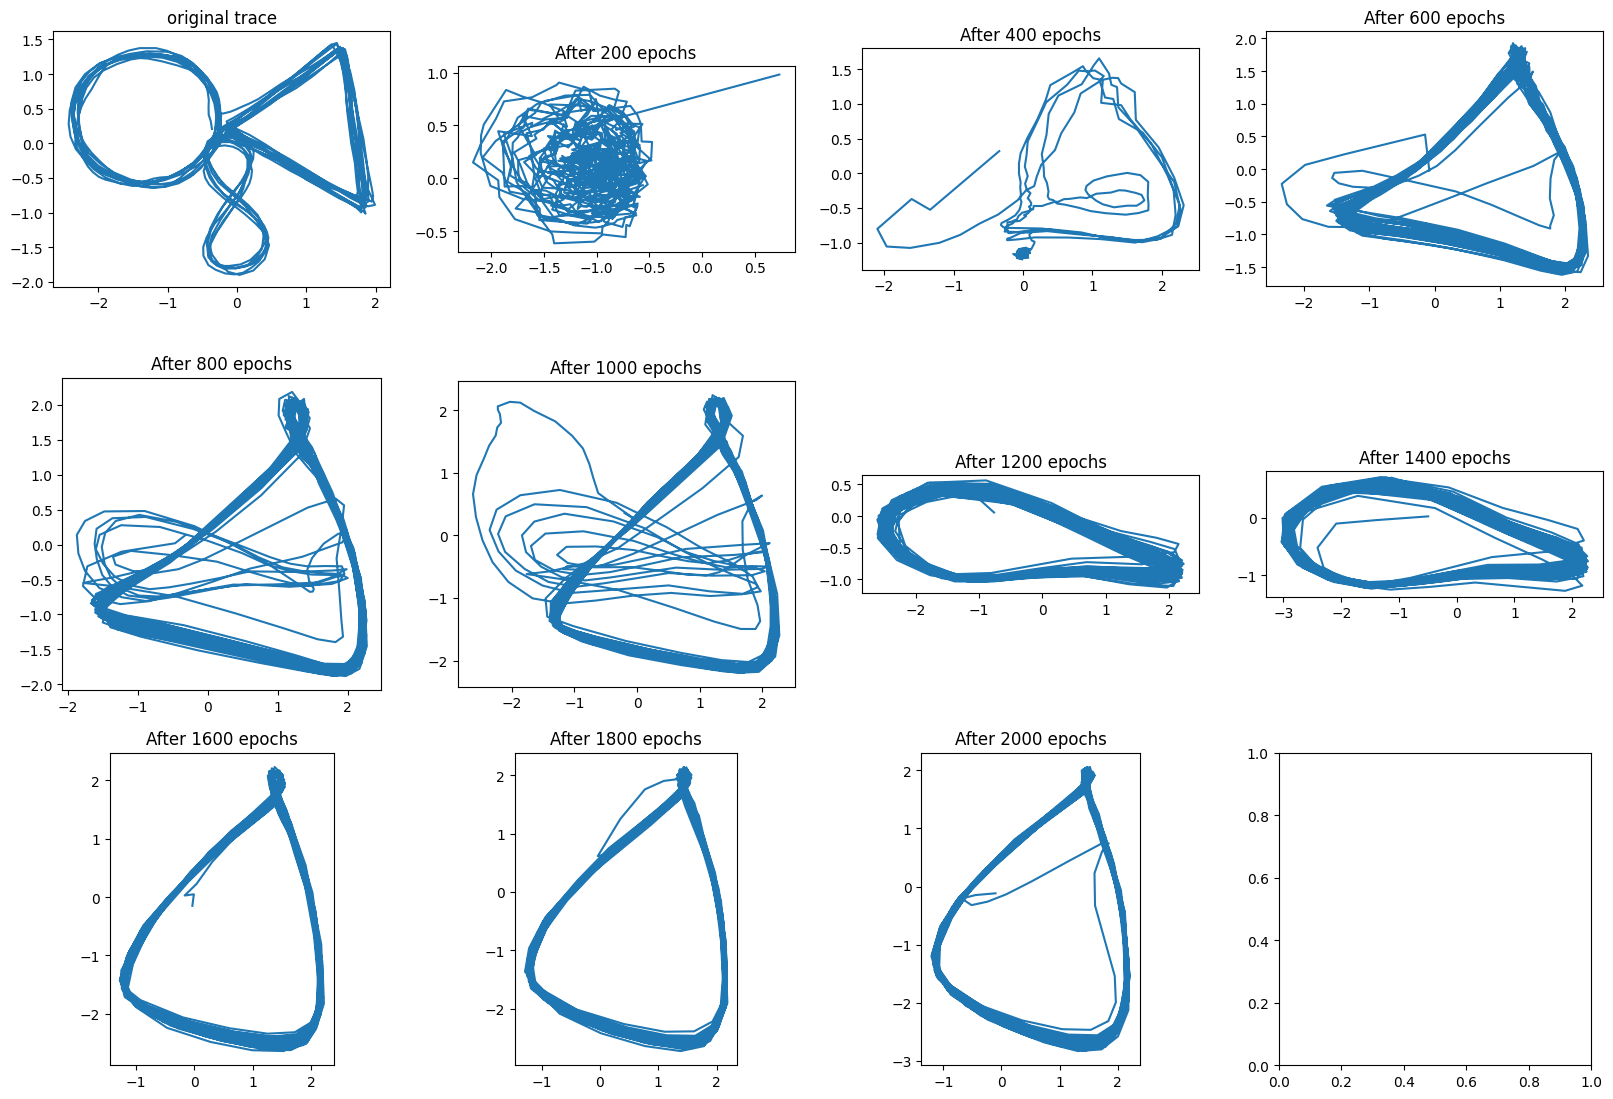

In [36]:
n_traces = len(all_generated)

if n_traces > 3:
    n_rows = int(np.floor(np.sqrt(n_traces + 1)))
    n_cols = int(np.ceil((n_traces+1) / n_rows))
else:
    n_cols = n_traces + 1 
    n_rows = 1
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(5*n_cols, 4.6*n_rows))
for ax in axs:
    if type(ax) == np.ndarray:
        for _ax in ax:
            _ax.set_aspect('equal')
    else:
        ax.set_aspect('equal')
original = coordinates.cpu().detach()
if n_rows > 1:
    ax0 = axs[0,0]
else:
    ax0 = axs[0]
ax0.plot(original[:,0], original[:,1])
ax0.set_title('original trace')
for trace in range(n_traces):
    gen_coordinates = all_generated[trace]
    if n_rows == 1:
        ax = axs[trace+1]
    else:
        row = int(np.floor((trace+1)/n_cols))
        col = int(np.ceil((trace+1)%n_cols)) 
        ax = axs[row, col]
    ax.set_title(f'After {n_epochs*(trace+1)} epochs')
    ax.plot(gen_coordinates[:,0], gen_coordinates[:,1])

In [ ]:
# plot a direction field
lim_x = 2. # largest magnitude of x
lim_y = 2.
N_x = 4 # number of points in x dimension
N_y = 4
n_points = 50
#df_fig = plt.figure(figsize = (10,10))
fig = plt.figure(figsize=(6,6))
plt.xlim(-1.1*lim_x, 1.1*lim_x)
plt.ylim(-1.1*lim_y, 1.1*lim_y)
plt.axis('equal')
plt.title(f'{n_points} iterations on {N_x}x{N_y} initial positions')
for x in np.linspace(-lim_x, lim_x, N_x):
    for y in np.linspace(-lim_y, lim_y, N_y):
        #print(f"x = {x}, y = {y}")
        plt.scatter([x], [y], color='tab:pink')
        coordinate = torch.tensor([x, y], dtype=torch.float32)
        trajectory = generate_trajectory(coordinate, n_points)
        plt.scatter([trajectory[0, 0]], [trajectory[0,1]], color='tab:cyan')
        plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.show()

In [ ]:
# plot a direction field
lim_x = 2. # largest magnitude of x
lim_y = 2.
N_x = 4 # number of points in x dimension
N_y = 4
n_points = 50
#df_fig = plt.figure(figsize = (10,10))
fig = plt.figure(figsize=(6,6))
plt.xlim(-1.1*lim_x, 1.1*lim_x)
plt.ylim(-1.1*lim_y, 1.1*lim_y)
plt.axis('equal')
plt.title(f'{n_points} iterations on {N_x}x{N_y} initial positions')
for x in np.linspace(-lim_x, lim_x, N_x):
    for y in np.linspace(-lim_y, lim_y, N_y):
        #print(f"x = {x}, y = {y}")
        plt.scatter([x], [y], color='tab:pink')
        coordinate = torch.tensor([x, y], dtype=torch.float32)
        trajectory = generate_trajectory(coordinate, n_points)
        plt.scatter([trajectory[0, 0]], [trajectory[0,1]], color='tab:cyan')
        plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.show()